In [3]:
from nni.nas.nn.pytorch import Cell, LayerChoice, InputChoice, ModelSpace, MutableModule
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

2330 runs loaded.


Text(0.5, 1.0, 'RadarCell: Parameters vs Final Validation Loss')

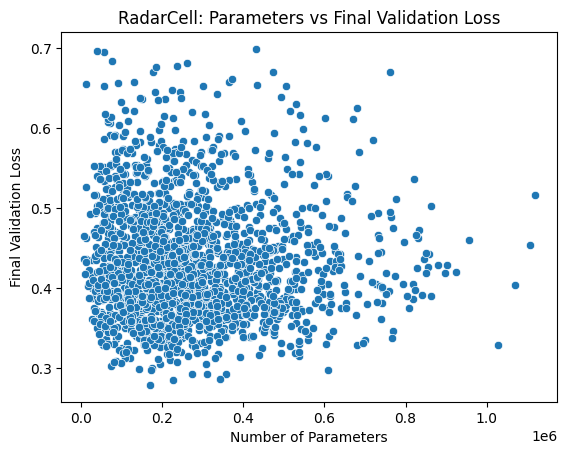

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv("exploration_with_training.csv")
df = df.replace([np.inf, -np.inf, np.nan], 0)
print(f"{df.shape[0]} runs loaded.")
# df["log_lambda_0"] = np.log10(df["ntk_lambda_0"])
df = df[df['final_val_loss'] < 0.7]  # Filter out invalid runs
# df["ntk_condition_number"] = np.log10(df["ntk_condition_number"] + 1e-10)
df["ntk_lambda_0"] = np.log10(df["ntk_lambda_0"] + 1e-10)
sns.scatterplot(data=df, x="params", y="final_val_loss")
plt.xlabel("Number of Parameters")
plt.ylabel("Final Validation Loss")
plt.title("RadarCell: Parameters vs Final Validation Loss")

In [5]:
bad_archs = df[df['final_val_loss'] >= 0.95]
print("Bad architectures:")
print(bad_archs[['architecture', 'final_val_loss']])

Bad architectures:
Empty DataFrame
Columns: [architecture, final_val_loss]
Index: []


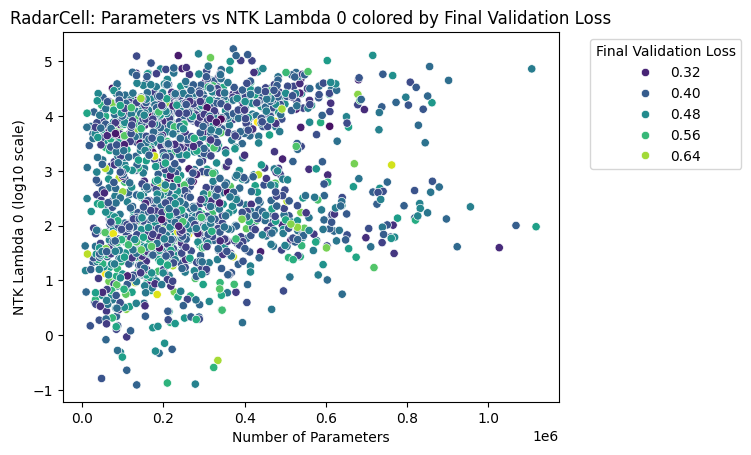

In [6]:
sns.scatterplot(data=df, x="params", y="ntk_lambda_0", hue="final_val_loss", palette="viridis")
plt.xlabel("Number of Parameters")
plt.ylabel("NTK Lambda 0 (log10 scale)")
plt.title("RadarCell: Parameters vs NTK Lambda 0 colored by Final Validation Loss")
plt.legend(title="Final Validation Loss", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

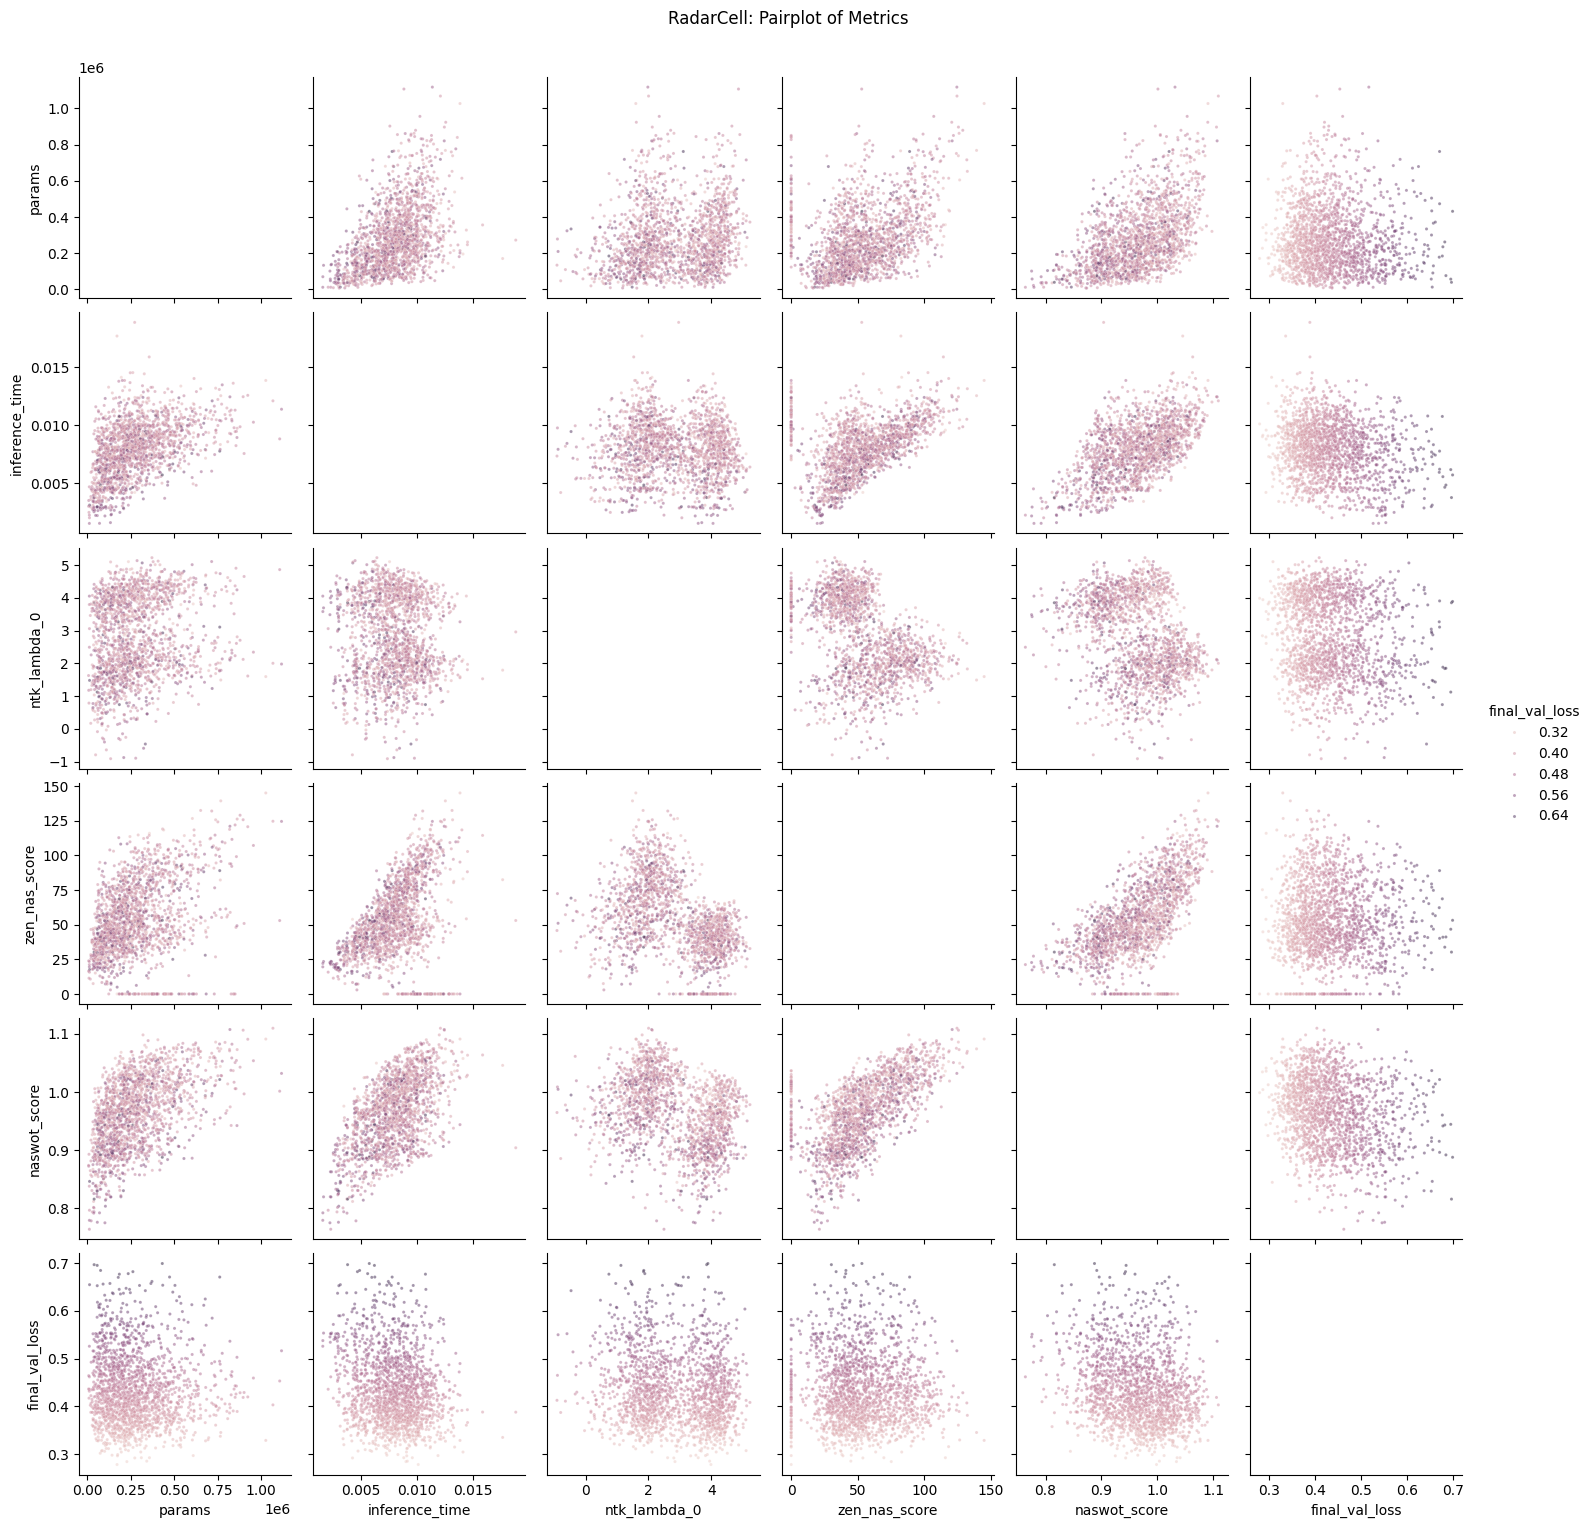

In [7]:
sns.pairplot(df, vars=["params", "inference_time", "ntk_lambda_0", "zen_nas_score", "naswot_score", "final_val_loss"],
              diag_kind="kde", plot_kws={"alpha": 0.5, "s":5}, hue="final_val_loss")
plt.suptitle("RadarCell: Pairplot of Metrics", y=1.02)
plt.show()

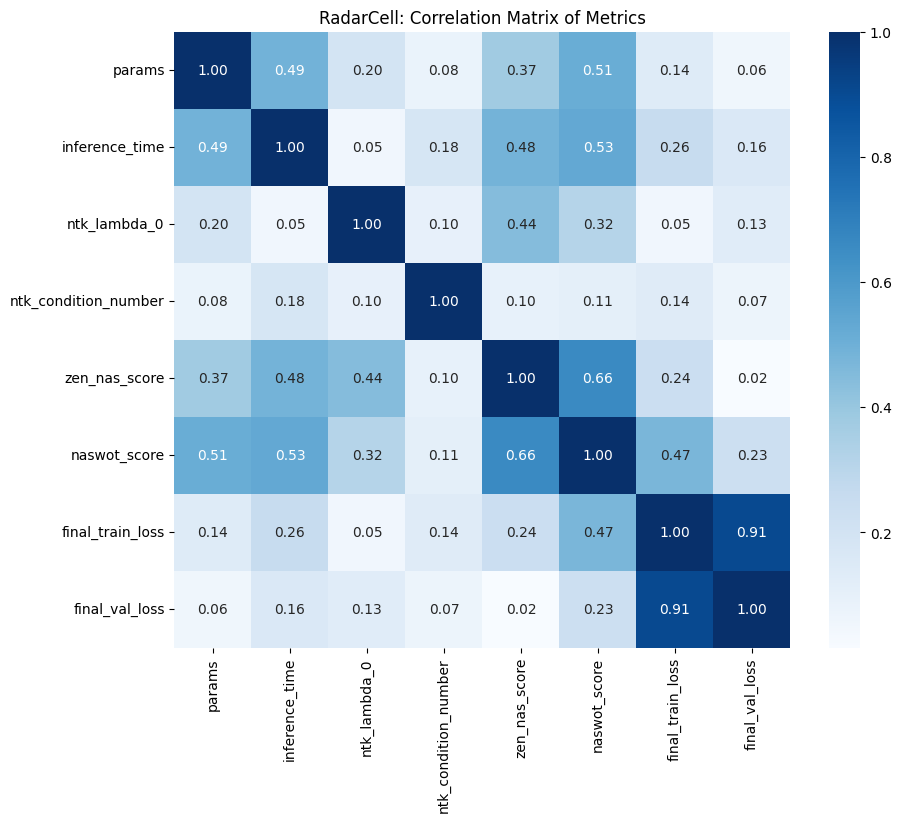

In [8]:
df_corr = df[df.columns[1:]]
corr_matrix = np.abs(df_corr.corr("spearman"))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.title("RadarCell: Correlation Matrix of Metrics")
plt.show()

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

X = df[['ntk_lambda_0', 'zen_nas_score', 'naswot_score', 'params']].copy()
X = X.fillna(0)
y = df['final_val_loss']

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
# Prepare the features and target

# Fit Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)

# Print results
print("Gradient Boosting Results:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print("\nFeature Importances:")
for feature, importance in zip(X_train.columns, model.feature_importances_):
    print(f"  {feature}: {importance:.4f}")


Training set size: 1247
Validation set size: 267
Test set size: 268
Gradient Boosting Results:
R² Score: 0.1474
RMSE: 0.0662

Feature Importances:
  ntk_lambda_0: 0.2655
  zen_nas_score: 0.1493
  naswot_score: 0.3612
  params: 0.2240


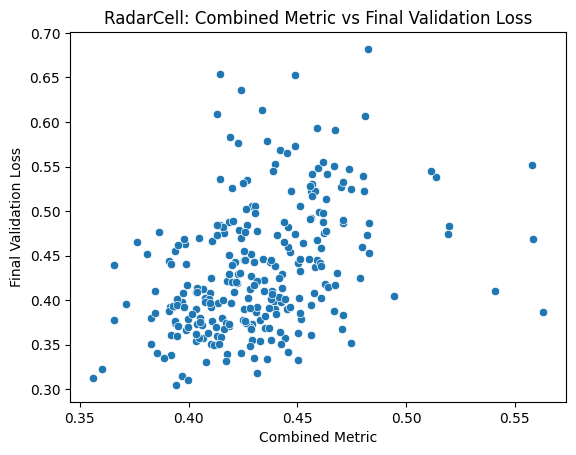

0.3894176659648709


In [10]:
new_metric = model.predict(X_test)
sns.scatterplot(x=new_metric, y=y_test)
plt.xlabel("Combined Metric")
plt.ylabel("Final Validation Loss")
plt.title("RadarCell: Combined Metric vs Final Validation Loss")
plt.show()
print(np.corrcoef(new_metric, y_test)[0, 1])

<Axes: xlabel='params', ylabel='Count'>

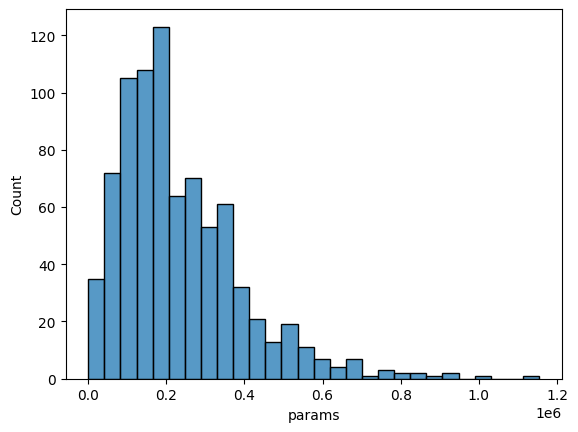

In [176]:
df_random = pd.read_csv("random_architectures.csv")
sns.histplot(df_random['params'], label='Number of parameters', fill=True)

In [46]:
df_random.sort_values(by='params', inplace=True, ascending=False)
df_random.head()

,architecture,params,inference_time_cpu,inference_time_gpu
657,64:64:64:8:64:16:64|d3r2:d3r4:d3r4:d3r4:d3r2:c1x5,1154153,1.526207,0.052445
344,32:64:64:8:64:64:64|dw3x3:d3r2:d3r2:c1x5:c1x3:...,1023401,1.459959,0.046410
90,64:64:64:32:64:32:64|d3r4:id:c1x1:d3r4:d3r4:d3r4,939417,0.804769,0.036588
265,64:32:64:32:32:32:64|c1x5:d3r4:d3r4:d3r4:c1x3:...,916089,0.708379,0.043499
238,64:32:64:8:64:64:32|d3r2:d3r2:d3r4:c1x5:d3r2:z,882873,0.837728,0.051493


<Axes: xlabel='params', ylabel='inference_time_gpu'>

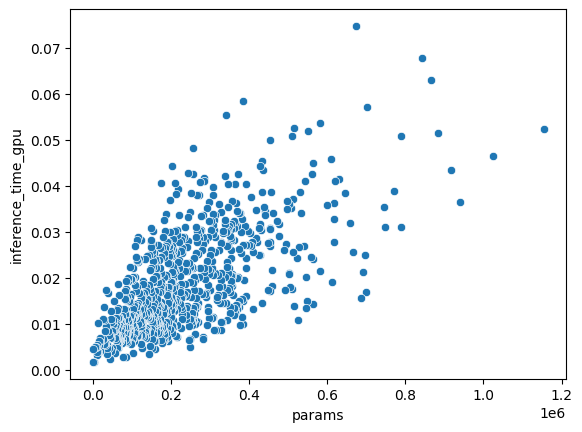

In [47]:
sns.scatterplot(data=df_random, x="params", y="inference_time_gpu")